# A* sampling

In [232]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from IPython.display import HTML, set_matplotlib_formats

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

set_matplotlib_formats('pdf', 'svg')
css_style = open('../../../_static/custom_style.css', 'r').read()
HTML(f'<style>{css_style}</style>')

## Gumbel distributions

## Gumbel Processes

<div class="definition">
   
**Definition (Gumbel Process)** Suppose $(\Omega, \mathcal{F}, \mu)$ is a measurable space where $\mu$ be is a [sigma-finite measure](https://en.wikipedia.org/wiki/%CE%A3-finite_measure) (i.e. a bound measure), and let $X_\mu(B) \in \Omega, G_\mu(B) \in \mathbb{R}$ be random variables. Then, the random process $\mathcal{G}_\mu = \left\{\left(X_{\mu}(B), G_{\mu}(B)\right) | B \in \mathcal{F}\right\}$ is a Gumbel process if it satisfies
    
$$\begin{align}    
& X_{\mu}(B) \sim \mu_B \text{ and } G_{\mu}(B) \sim \text{Gumbel}\left(\log \mu (B)\right) && \text{(marginal distribution of Gumbels)} \\
& X_{\mu}(B), G_{\mu}(B) \perp X_{\mu}\left(B^c\right), G_{\mu}\left(B^c\right) && \text{(independence)} \\
& G_{\mu}(A \cup B) = \max\left\{G_{\mu}(A), G_{\mu}(B)\right\} && \text{(consistency)} \\
\end{align}$$
    
where $\pi_B$ denotes restricting the measure $\mu$ to the set $B$ and normalising it.

</div>
<br>

Note that this definition includes the distribution of the argmax, which was not included in the A* paper.
Though the original paper defines this (in Algorithm 1 of the paper), I have found it clearer to include it in the definition of the process.

In the case where $\Omega$ is finite, the colletion of random variables $G_{\mu}$ corresponds to maxima over different subsets of a set of numbers which have been perturbed by independent Gumbel noise.

## Sampling a Gumbel process

Given a base measure $\mu$ we can, in principle, realise samples from the Gumbel process $\mathcal{G}_{\mu}$ in the following manner. First, we can set $B_1 = \Omega$ and sample the global maximum of the Gumbel process according to

$$\begin{align}
G_{\mu}(B_1) \sim \text{Gumbel}\left(\log \mu (B_1)\right),
\end{align}$$

which follows from the definition of the Gumbel process. We can sample $X_{\mu}(B_1) \sim \mu_{B_1}$, and parition $B_1 - \{X_{\mu}(B_1)\}$ into disjoint subsets $B_2$ and $B_3$ using an arbitrary partitioning method. We can then proceed recursively, by sampling $G_\mu(B_2)$ and $G_\mu(B_3)$. By the definition of the Gumbel process, we have the fact that

$$\begin{align}
p\left(G_{\mu}(B_2) = g_2, G_{\mu}(B_3) = g_3 | G_{\mu}(B_1) = g_1\right) = p\left(G_{\mu}(B_2) = g_2 | G_{\mu}(B_1) = g_1\right)~p\left(G_{\mu}(B_3) = g_3 | G_{\mu}(B_1) = g_1\right), 
\end{align}$$

where it can be shown that each of these conditionals takes the form of a truncated Gumbel

$$\begin{align}
p\left(G_{\mu}(B_2) = g_2 | G_{\mu}(B_1) = g_1 \right) = \mathbf{1}\left(g_2 \leq g_1 \right) p\left(G_{\mu}(B_2) = g_2\right) = \text{TruncatedGumbel}(g_2; \log \mu(B_{n+1}), g_1),
\end{align}$$

and similarly for $G_{\mu}(B_3)$. We can also sample the corresponding $X_{\mu}(B_2)$ and $X_{\mu}(B_3)$ and proceed iteratively to obtain samples from the Gumbel process.
This method for sampling is called the top-down construction.
Note that in each recursive step, we can alternatively split the current index set to an arbitrary number of subsets or not split it at all.

<div class="definition">
   
**Algorithm (Construction of a Gumbel process)** Given a sample space $\Omega$ and a base measure $\mu$, we can realise the top-$N$ samples from the Gumbel proceess $\mathcal{G}_\mu$ as follows
    
1. Initialise $B_1 \gets \Omega$, $n \gets 1$, $Q \gets \text{Queue}$.
2. Push at end of queue $Q.\texttt{push}(1)$.
3. Sample $X_1 \sim \mu_{|_{B_1}}$ and $G_1 \sim \text{Gumbel}(\log \mu(B_1))$.
4. Pop from queue $m \gets Q.\texttt{pop}()$.
5. For $C \in \texttt{partition}\left(B_m - \{X_m\}\right)$
    1. Set $B_{n+1} \gets C$.
    2. Sample $X_{n+1} \sim \mu_{|_{B_{n+1}}}$.
    3. Sample $G_{n+1} \sim \text{TruncatedGumbel}(\log \mu(B_{n+1}), G_m)$.
    4. Set $n \gets n + 1$.
    5. Push to queue $Q.\texttt{push}(n)$.
    6. If $n \geq N$ exit.
6. Go to step 4, otherwise return $\left\{(X_n, G_n)\right\}_{n=1}^N$.

</div>
<br>

In [461]:
import numpy as np
import matplotlib.pyplot as plt

from queue import PriorityQueue
from scipy.stats import norm as normal
from scipy.stats import gumbel_r as gumbel

def sample_truncated(log_cdf, ppf, a, b):
    
    # Draw proportion of Z at which the sample is located
    u = np.random.uniform()
    
    # Sample has CDF equal to the CDF at the left boundary plus
    # the random proportion of the CDF between the two boundaries
    cdf = np.exp(np.logaddexp(log_cdf(a) + np.log(1 - u), np.log(u) + log_cdf(b)))
    sample = ppf(cdf)
    
    return sample


def partition_at_sample(left, right, sample):
    
    # Yield partition left of sample - interval [left, sample]
    yield left, sample
    
    # Yield partition right of sample - interval [sample, right]
    yield sample, right
    

def sample_gubmel_top_down(log_cdf, ppf, num_samples):
    
    # Counter for number of samples drawn
    n = 0
    
    # Set up queue and push zero in it - note that when called with a single
    # argument, the queue is not a priority but a first-in-first-out queue
    queue = PriorityQueue()
    queue.put(0)
    
    # Set up initial bounds
    B = {
        0 : (float("-inf"), float("inf"))
    }
    
    # Draw first sample
    X = {
        0 : sample_truncated(
            log_cdf=log_cdf,
            ppf=ppf,
            a=B[0][0],
            b=B[0][1]
        )
    }
    
    # Draw first gumbel
    g = gumbel(loc=0.)
    G = {
        0 : sample_truncated(
            log_cdf=gumbel.logcdf,
            ppf=gumbel.ppf,
            a=float("-inf"),
            b=float("inf")
        )
    }
    
    # Iterate until enough samples have been yielded
    while True:
        
        # Get index to search next
        m = queue.get()
        
        # Create partition at sample
        partitions = partition_at_sample(
            left=B[m][0],
            right=B[m][1],
            sample=X[m]
        )
        
        # For each of the two partitions sample X and G
        for partition in partitions:
            
            if n >= num_samples - 1: return X, G
            
            B[n+1] = partition
            
            X[n+1] = sample_truncated(
                log_cdf=log_cdf,
                ppf=ppf,
                a=B[n+1][0],
                b=B[n+1][1]
            )
            
            log_mass = np.log(np.exp(log_cdf(B[n+1][1])) - np.exp(log_cdf(B[n+1][0])))
            
            g = gumbel(loc=log_mass)
            G[n+1] = sample_truncated(
                log_cdf=g.logcdf,
                ppf=g.ppf,
                a=float("-inf"),
                b=G[m]
            )
            
            # Iterate sample counter and update queue
            n = n + 1
            queue.put(n)

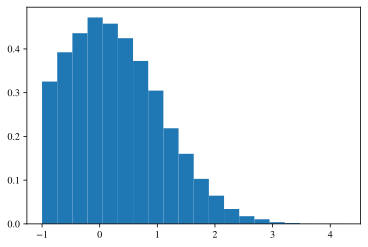

In [546]:
_normal = normal(loc=0., scale=1.)
log_cdf = _normal.logcdf
ppf = _normal.ppf
a = -1.
b = float("inf")

samples = [sample_truncated(log_cdf=log_cdf, ppf=ppf, a=a, b=b) for i in range(50000)]

plt.hist(samples, bins=20, density=True)
plt.show()

In [462]:
np.random.seed(3)

_normal = normal(loc=0., scale=1.)
normal_log_cdf = _normal.logcdf
normal_ppf = _normal.ppf
num_samples = 7

X, G = sample_gubmel_top_down(
    log_cdf=normal_log_cdf,
    ppf=normal_ppf,
    num_samples=num_samples
)

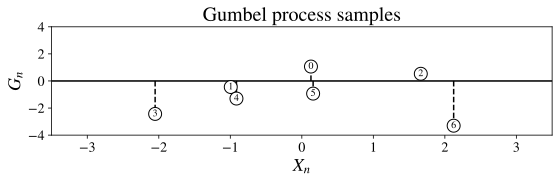

In [463]:
number_style = {
    "boxstyle" : "circle, pad=0.2",
    "fc"       : "white"
}

plt.figure(figsize=(9, 2))

for n in range(num_samples):
    
    plt.plot([X[n], X[n]], [0., G[n]], "--", color="k")
    plt.text(
        x=X[n],
        y=G[n],
        s=f"{n}",
        ha="center",
        va="center",
        bbox=number_style
    )
    
plt.plot([-3.5, 3.5], [0, 0], c="black")

plt.title("Gumbel process samples", fontsize=20)
plt.xlabel("$X_n$", fontsize=18)
plt.ylabel("$G_n$", fontsize=18)

plt.xticks(np.linspace(-3., 3., 7), fontsize=14)
plt.yticks(np.linspace(-4., 4., 5), fontsize=14)

plt.xlim([-3.5, 3.5])
plt.ylim([-4, 4])

plt.show()

## The A* sampling algorithm

<div class="definition">
   
**Algorithm (Construction of a Gumbel process)** Given a sample space $\Omega$ and a tractable log-density $\log p(x)$, an unnormalised target distribution $q(x)$ and corresponding log-ratio $\log r(x) = \log q(x) - \log p(x)$, a bounding function $M$ for $r$ and a $\texttt{patition}$ function, the A* sampling algorithm is
    
1. Initialise $B_1 \gets \Omega$, $n \gets 1$, $Q \gets \text{PriorityQueue}$.
2. Sample $X_1 \sim p_{|_{B_1}}$ and $G_1 \sim \text{Gumbel}(\log \mu(B_1))$.
3. Set $L \gets G_1 + \log r(X_1)$ and $X^* \gets X_1$.
4. Push to queue with priority $Q.\texttt{push_with_priority}(1, G_1 + M(B_1))$.
5. If $Q.\texttt{top-priority}() \leq L$ return $X^*$.
6. Pop highest priority entry $m \gets Q.\texttt{pop-highest}()$.
7. Set lower bound for current interval $L_m \gets G_m + \log r(X_m)$.
8. If $L_m < L$, set $L \gets L_m$ and $X^*$
9. For $C \in \texttt{partition}\left(B_m - \{X_m\}\right)$
    1. Set $B_{n+1} \gets C$.
    2. Sample $X_{n+1} \sim p_{|_{B_{n+1}}}$.
    3. Sample $G_{n+1} \sim \text{TruncatedGumbel}(\log \mu(B_{n+1}), G_m)$.
    4. Set $n \gets n + 1$.
    5. Push to back of queue $Q.\texttt{push}(n)$.
    6. If $n \geq N$ exit.
10. Go to step 4, otherwise return $\left\{(X_n, G_n)\right\}_{n=1}^N$.

</div>
<br>

In [533]:
def gaussian_gaussian_log_ratio_and_bound(q_loc, q_scale):
    
    # Proposal distribution and log probability function
    p_loc = 0.
    p_scale = 1.
    
    proposal = normal(loc=0., scale=1.)
    
    # We constrain ourselves to the case where p_scale is smaller than
    # q_scale so that the log-ratio is unimodal and the bounding function
    # M is easy to write down
    assert q_scale <= p_scale
    
    _normal = normal(loc=p_loc, scale=p_scale)
    _log_p = _normal.logpdf
    
    # Mode of log ratio
    mode = (p_loc * q_scale**2 + q_loc * p_scale**2) / (p_scale**2 + q_scale**2)
    
    def log_r(x):
        
        # Unnormalised log-probability of target distribution
        log_q = -0.5 * ((x - q_loc) / q_scale)**2
        
        return log_q - log_p(x)
    
    
    def M(B):
        
        # Unpack interval limits and check they are valid
        left, right = B
        
        assert left < right
        
        # Mode
        M = max(
            log_r(left) if left != float("-inf") else 0,
            log_r(right) if right != float("inf") else 1
        )
        
        if left <= mode and right >= mode:
            M = log_r(mode)
        
        return M
        
    return proposal, log_r, M


def a_star(p_log_cdf, p_ppf, log_r, M):
    
    # Initialise counter and lower bound
    n = 0
    L = float("-inf")
    X_star = None
    
    # Set up initial intervals
    B = {
        0 : (float("-inf"), float("inf"))
    }
    
    # Draw first sample
    X = {
        0 : sample_truncated(
            log_cdf=p_log_cdf,
            ppf=p_ppf,
            a=B[0][0],
            b=B[0][1]
        )
    }
    
    # Draw first gumbel
    g = gumbel(loc=0.)
    G = {
        0 : sample_truncated(
                log_cdf=gumbel.logcdf,
                ppf=gumbel.ppf,
                a=float("-inf"),
                b=float("inf")
            )
    }
    
    # Set up upper bound dictionary
    U = {
        0 : G[0] + M(B[0])
    }
    
    # Set up priority queue - PriorityQueue puts low priority first by default
    # so we need to insert elements using the negative lower bound
    queue = PriorityQueue()
    queue.put((- G[0] - M(B[0]), 0))
    
    # Iterate until enough samples have been yielded
    while True:
        
        # Get index to search next
        if queue.empty():
            return X_star, m, X, G, U, L
        
        Um, m = queue.get()
        U[m] = - Um
        
        L_interaval = G[m] + log_r(X[m])
        
        if L < L_interaval:
            L = L_interaval
            X_star = X[m]
            
        # Check if current lower bound higher than highest upper bound
        if U[m] <= L:
            return X_star, m, X, G, U, L
        
        # Create partition at sample
        partitions = partition_at_sample(
            left=B[m][0],
            right=B[m][1],
            sample=X[m]
        )
        
        # For each of the two partitions sample X and G
        for partition in partitions:
            
            B[n+1] = partition
            
            X[n+1] = sample_truncated(
                log_cdf=p_log_cdf,
                ppf=p_ppf,
                a=B[n+1][0],
                b=B[n+1][1]
            )
            
            log_mass = np.log(np.exp(p_log_cdf(B[n+1][1])) - np.exp(p_log_cdf(B[n+1][0])))
            
            g = gumbel(loc=log_mass)
            G[n+1] = sample_truncated(
                log_cdf=g.logcdf,
                ppf=g.ppf,
                a=float("-inf"),
                b=G[m]
            )
            
            if L < G[n+1] + M(B[n+1]):
                queue.put((- G[n+1] - M(B[n+1]), n+1))
            
            # Iterate counter
            n = n + 1

In [535]:
np.random.seed(0)

q_loc = 2.0
q_scale = 0.5
proposal, log_r, M = gaussian_gaussian_log_ratio_and_bound(
    q_loc=q_loc,
    q_scale=q_scale
)

samples = []

for i in range(500):
    
    samples.append(a_star(
    p_log_cdf=proposal.logcdf,
    p_ppf=proposal.ppf,
    log_r=log_r,
    M=M
    )[0])

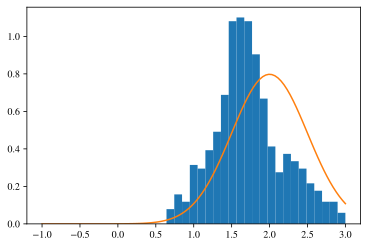

In [536]:
x = np.linspace(-1., 3., 100)

plt.hist(samples, bins=np.linspace(-1., 3., 40), density=True)
plt.plot(x, normal(loc=q_loc, scale=q_scale).pdf(x))
plt.show()